import os
os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'
# Option 6: SSL with Segmentation Channel Input

This notebook implements **Option 6** for chest X-ray classification using Self-Supervised Learning (SSL).

## Approach
- **Input**: 2-channel input consisting of:
  1. Grayscale chest X-ray image
  2. Rule-based lung segmentation mask
- **Pretraining**: Contrastive learning (SimCLR-style) on the 2-channel input
- **Fine-tuning**: Multi-label classification for 14 diseases

## Key Features
- Preserves all original image information
- Provides anatomical context through segmentation channel
- Uses SSL pretraining before supervised fine-tuning

## 1. Setup and Imports

In [34]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable optimizations if available
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if hasattr(torch.backends.cudnn, 'allow_tf32'):
        torch.backends.cudnn.allow_tf32 = True
    if hasattr(torch.cuda, 'matmul'):
        torch.backends.cuda.matmul.allow_tf32 = True

print("✅ Setup complete")

Using device: cuda
✅ Setup complete


## 2. Configuration

In [35]:
class CFG:
    # Data
    img_size = 224
    in_channels = 2  # grayscale image + segmentation mask
    
    # Training
    batch_size = 32
    pretrain_epochs = 5
    finetune_epochs = 50
    pretrain_lr = 1e-3
    finetune_lr = 1e-4
    
    # SSL
    temperature = 0.5
    projection_dim = 128
    
    # Device
    device = device
    
    # Subset for testing (set to None for full dataset)
    subset_size = None

cfg = CFG()
print(f"Configuration: img_size={cfg.img_size}, in_channels={cfg.in_channels}")
print(f"Pretrain epochs: {cfg.pretrain_epochs}, Finetune epochs: {cfg.finetune_epochs}")

Configuration: img_size=224, in_channels=2
Pretrain epochs: 5, Finetune epochs: 50


## 3. Data Loading

In [36]:
# Check environment and load data
IN_KAGGLE = os.path.exists('/kaggle/input')
IN_COLAB = 'google.colab' in sys.modules

if IN_KAGGLE:
    data_dir = Path('/kaggle/input/nih-chest-xrays')
    checkpoint_dir = Path('/kaggle/working/checkpoints')
elif IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = Path('/content/nih-chest-xrays')
    checkpoint_dir = Path('/content/drive/MyDrive/chest_xray_ssl')
else:
    # Local environment - use kagglehub
    try:
        import kagglehub
        data_dir = Path(kagglehub.dataset_download('nih-chest-xrays/data'))
    except:
        data_dir = Path('./data/nih-chest-xrays')
    checkpoint_dir = Path('./checkpoints')

checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Data directory: {data_dir}")
print(f"Checkpoint directory: {checkpoint_dir}")

Data directory: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
Checkpoint directory: checkpoints


In [37]:
# Load metadata
csv_path = data_dir / 'Data_Entry_2017.csv'
df = pd.read_csv(csv_path)

# Disease categories
disease_categories = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

# Create binary labels for each disease
for disease in disease_categories:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Find image paths
image_dirs = list(data_dir.glob('images_*/images'))
if not image_dirs:
    image_dirs = [data_dir / 'images']

image_path_map = {}
for img_dir in image_dirs:
    for img_path in img_dir.glob('*.png'):
        image_path_map[img_path.name] = str(img_path)

df['Image Path'] = df['Image Index'].map(image_path_map)
df = df.dropna(subset=['Image Path'])

if cfg.subset_size:
    df = df.sample(n=min(cfg.subset_size, len(df)), random_state=42)

print(f"Total samples: {len(df)}")
print(f"Disease distribution:")
print(df[disease_categories].sum())

Total samples: 112120
Disease distribution:
Atelectasis           11559
Cardiomegaly           2776
Effusion              13317
Infiltration          19894
Mass                   5782
Nodule                 6331
Pneumonia              1431
Pneumothorax           5302
Consolidation          4667
Edema                  2303
Emphysema              2516
Fibrosis               1686
Pleural_Thickening     3385
Hernia                  227
dtype: int64


## 4. Rule-Based Lung Segmentation

In [38]:
# ============================================
# Load Pre-Computed Lung Masks
# ============================================
# Masks pre-computed by precompute_lung_masks.ipynb

if IN_KAGGLE:
    PIXEL_MASK_DIR = "/kaggle/working/lung_masks/pixel_masks"
elif IN_COLAB:
    PIXEL_MASK_DIR = "/content/drive/MyDrive/lung_masks/pixel_masks"
else:
    PIXEL_MASK_DIR = "./lung_masks/pixel_masks"

def load_precomputed_mask(img_name, mask_dir=PIXEL_MASK_DIR, img_size=224):
    """Load pre-computed pixel-level lung mask from disk."""
    mask_name = img_name.replace(".png", "")
    mask = np.load(os.path.join(mask_dir, f"{mask_name}.npy"))
    if mask.dtype == np.uint8:
        mask = mask.astype(np.float32) / 255.0
    if mask.shape[0] != img_size or mask.shape[1] != img_size:
        mask = cv2.resize(mask, (img_size, img_size))
    return mask

print(f"Pixel mask directory: {PIXEL_MASK_DIR}")


✅ Lung segmentation function defined


## 5. Dataset Classes

In [39]:
class SSLAugmentation:
    """Augmentations for SSL pretraining with 2-channel input."""
    
    def __init__(self, img_size=224):
        self.img_size = img_size
    
    def __call__(self, image, mask):
        """Apply random augmentations to both image and mask consistently."""
        # Random horizontal flip
        if np.random.random() > 0.5:
            image = np.fliplr(image).copy()
            mask = np.fliplr(mask).copy()
        
        # Random rotation (-15 to 15 degrees)
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        
        # Random brightness/contrast adjustment (image only)
        if np.random.random() > 0.5:
            alpha = np.random.uniform(0.8, 1.2)  # contrast
            beta = np.random.uniform(-0.1, 0.1)  # brightness
            image = np.clip(alpha * image + beta, 0, 1)
        
        # Random Gaussian noise (image only)
        if np.random.random() > 0.5:
            noise = np.random.normal(0, 0.02, image.shape)
            image = np.clip(image + noise, 0, 1)
        
        # Ensure mask is binary
        mask = (mask > 0.5).astype(np.float32)
        
        return image.astype(np.float32), mask.astype(np.float32)


class SSLPretrainDataset(Dataset):
    """Dataset for SSL pretraining with 2-channel input."""
    
    def __init__(self, df, img_size=224):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.augmentation = SSLAugmentation(img_size)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and preprocess image
        img = Image.open(row['Image Path']).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        
        # Generate segmentation mask
        img_name = self.df.iloc[idx]["Image Index"]
        mask = load_precomputed_mask(img_name)
        if mask.shape != img.shape:
            mask = cv2.resize(mask, (self.img_size, self.img_size))
        
        # Create two augmented views
        img1, mask1 = self.augmentation(img.copy(), mask.copy())
        img2, mask2 = self.augmentation(img.copy(), mask.copy())
        
        # Stack image and mask as 2 channels
        view1 = np.stack([img1, mask1], axis=0)
        view2 = np.stack([img2, mask2], axis=0)
        
        return torch.tensor(view1), torch.tensor(view2)


class ClassificationDataset(Dataset):
    """Dataset for fine-tuning with 2-channel input."""
    
    def __init__(self, df, disease_categories, img_size=224, augment=False):
        self.df = df.reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        self.augment = augment
        self.augmentation = SSLAugmentation(img_size) if augment else None
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and preprocess image
        img = Image.open(row['Image Path']).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        
        # Generate segmentation mask
        img_name = self.df.iloc[idx]["Image Index"]
        mask = load_precomputed_mask(img_name)
        if mask.shape != img.shape:
            mask = cv2.resize(mask, (self.img_size, self.img_size))
        
        # Apply augmentation if enabled
        if self.augment and self.augmentation:
            img, mask = self.augmentation(img, mask)
        
        # Stack as 2 channels
        combined = np.stack([img, mask], axis=0)
        combined = torch.tensor(combined, dtype=torch.float32)
        
        # Get labels
        labels = torch.tensor(
            [row[d] for d in self.disease_categories],
            dtype=torch.float32
        )
        
        return combined, labels

print("✅ Dataset classes defined")

✅ Dataset classes defined


## 6. Model Architecture

In [40]:
def get_resnet50_multichannel(in_channels=2, pretrained=True):
    """
    Create a ResNet50 backbone modified for 2-channel input.
    Adapts pretrained weights by averaging RGB channels.
    """
    model = models.resnet50(pretrained=pretrained)
    
    # Get original first conv layer
    original_conv = model.conv1
    
    # Create new conv layer with desired input channels
    new_conv = nn.Conv2d(
        in_channels=in_channels,
        out_channels=original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=original_conv.bias is not None
    )
    
    # Initialize weights from pretrained model
    with torch.no_grad():
        if pretrained:
            # Average the RGB weights and replicate for each input channel
            original_weights = original_conv.weight.data
            avg_weight = original_weights.mean(dim=1, keepdim=True)
            new_conv.weight.data = torch.cat([avg_weight] * in_channels, dim=1)
            
            if original_conv.bias is not None:
                new_conv.bias.data = original_conv.bias.data.clone()
    
    model.conv1 = new_conv
    return model


class ProjectionHead(nn.Module):
    """Projection head for contrastive learning."""
    
    def __init__(self, in_dim, hidden_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class SSLModel(nn.Module):
    """SSL model with ResNet50 backbone and projection head."""
    
    def __init__(self, in_channels=2, projection_dim=128, pretrained=True):
        super().__init__()
        
        # Backbone
        self.backbone = get_resnet50_multichannel(in_channels, pretrained)
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        # Projection head for SSL
        self.projection = ProjectionHead(self.feature_dim, out_dim=projection_dim)
    
    def forward(self, x):
        features = self.backbone(x)
        projections = self.projection(features)
        return F.normalize(projections, dim=1)
    
    def get_features(self, x):
        return self.backbone(x)


class ClassificationModel(nn.Module):
    """Classification model using pretrained SSL backbone."""
    
    def __init__(self, ssl_model, num_classes=14, freeze_backbone=False):
        super().__init__()
        self.backbone = ssl_model.backbone
        self.feature_dim = ssl_model.feature_dim
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.feature_dim, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

print("✅ Model classes defined")

✅ Model classes defined


## 7. Contrastive Loss

In [41]:
class NTXentLoss(nn.Module):
    """NT-Xent loss for contrastive learning (SimCLR)."""
    
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, z1, z2):
        batch_size = z1.shape[0]
        
        # Concatenate representations
        z = torch.cat([z1, z2], dim=0)
        
        # Compute similarity matrix
        sim = torch.mm(z, z.t()) / self.temperature
        
        # Create mask for positive pairs
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        
        # Mask out self-similarities
        sim.masked_fill_(mask, float('-inf'))
        
        # Labels: positive pairs are at positions batch_size apart
        labels = torch.cat([
            torch.arange(batch_size, 2 * batch_size),
            torch.arange(batch_size)
        ]).to(z.device)
        
        loss = F.cross_entropy(sim, labels)
        return loss

print("✅ Contrastive loss defined")

✅ Contrastive loss defined


## 8. Training Functions

In [42]:
def pretrain_epoch(model, dataloader, optimizer, criterion, device):
    """Run one pretraining epoch."""
    model.train()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc="Pretraining")
    for view1, view2 in pbar:
        view1, view2 = view1.to(device), view2.to(device)
        
        optimizer.zero_grad()
        
        z1 = model(view1)
        z2 = model(view2)
        
        loss = criterion(z1, z2)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)


def finetune_epoch(model, dataloader, optimizer, criterion, device):
    """Run one fine-tuning epoch."""
    model.train()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc="Fine-tuning")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)


@torch.no_grad()
def evaluate(model, dataloader, device):
    """Evaluate model and return AUC scores."""
    model.eval()
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        outputs = torch.sigmoid(model(images))
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate AUC for each disease
    aucs = []
    for i in range(all_labels.shape[1]):
        if all_labels[:, i].sum() > 0:  # Only if there are positive samples
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            aucs.append(auc)
        else:
            aucs.append(0.5)
    
    return np.mean(aucs), aucs

print("✅ Training functions defined")

✅ Training functions defined


## 9. Data Preparation

In [43]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Create datasets
pretrain_dataset = SSLPretrainDataset(train_df, img_size=cfg.img_size)
train_dataset = ClassificationDataset(train_df, disease_categories, img_size=cfg.img_size, augment=True)
val_dataset = ClassificationDataset(val_df, disease_categories, img_size=cfg.img_size, augment=False)
test_dataset = ClassificationDataset(test_df, disease_categories, img_size=cfg.img_size, augment=False)

# Create dataloaders
pretrain_loader = DataLoader(pretrain_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("✅ Data prepared")

Train: 80726, Val: 8970, Test: 22424
✅ Data prepared


## 10. SSL Pretraining

In [44]:
# Initialize SSL model
ssl_model = SSLModel(
    in_channels=cfg.in_channels,
    projection_dim=cfg.projection_dim,
    pretrained=True
).to(cfg.device)

# Loss and optimizer for pretraining
ssl_criterion = NTXentLoss(temperature=cfg.temperature)
ssl_optimizer = optim.Adam(ssl_model.parameters(), lr=cfg.pretrain_lr)

print(f"SSL Model parameters: {sum(p.numel() for p in ssl_model.parameters()):,}")
print("\nStarting SSL Pretraining...")

pretrain_losses = []
for epoch in range(cfg.pretrain_epochs):
    loss = pretrain_epoch(ssl_model, pretrain_loader, ssl_optimizer, ssl_criterion, cfg.device)
    pretrain_losses.append(loss)
    print(f"Epoch {epoch+1}/{cfg.pretrain_epochs} - Loss: {loss:.4f}")

# Save pretrained model
torch.save(ssl_model.state_dict(), checkpoint_dir / 'option6_ssl_pretrained.pth')
print("\n✅ SSL Pretraining complete")

SSL Model parameters: 24,620,672

Starting SSL Pretraining...


Pretraining: 100%|██████████| 2523/2523 [15:13<00:00,  2.76it/s, loss=1.86]


Epoch 1/5 - Loss: 2.2630


Pretraining: 100%|██████████| 2523/2523 [13:47<00:00,  3.05it/s, loss=1.86]


Epoch 2/5 - Loss: 2.2205


Pretraining: 100%|██████████| 2523/2523 [13:48<00:00,  3.05it/s, loss=1.85]


Epoch 3/5 - Loss: 2.2098


Pretraining: 100%|██████████| 2523/2523 [13:50<00:00,  3.04it/s, loss=1.83]


Epoch 4/5 - Loss: 2.2033


Pretraining: 100%|██████████| 2523/2523 [13:47<00:00,  3.05it/s, loss=1.83]


Epoch 5/5 - Loss: 2.2007

✅ SSL Pretraining complete


## 11. Fine-tuning

In [45]:
# Initialize classification model with pretrained backbone
classifier = ClassificationModel(
    ssl_model,
    num_classes=len(disease_categories),
    freeze_backbone=False
).to(cfg.device)

# Loss and optimizer for fine-tuning
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=cfg.finetune_lr)

print(f"Classifier parameters: {sum(p.numel() for p in classifier.parameters()):,}")
print("\nStarting Fine-tuning...")

best_auc = 0
train_losses = []
val_aucs = []

for epoch in range(cfg.finetune_epochs):
    train_loss = finetune_epoch(classifier, train_loader, optimizer, criterion, cfg.device)
    val_auc, _ = evaluate(classifier, val_loader, cfg.device)
    
    train_losses.append(train_loss)
    val_aucs.append(val_auc)
    
    print(f"Epoch {epoch+1}/{cfg.finetune_epochs} - Loss: {train_loss:.4f}, Val AUC: {val_auc:.4f}")
    
    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(classifier.state_dict(), checkpoint_dir / 'option6_ssl_best.pth')
        print(f"  -> New best model saved!")

print(f"\n✅ Fine-tuning complete. Best Val AUC: {best_auc:.4f}")

Classifier parameters: 23,533,582

Starting Fine-tuning...


Evaluating: 100%|██████████| 281/281 [00:57<00:00,  4.93it/s]


Epoch 1/50 - Loss: 0.1831, Val AUC: 0.7089
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:43<00:00,  6.52it/s]


Epoch 2/50 - Loss: 0.1698, Val AUC: 0.7383
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.57it/s]


Epoch 3/50 - Loss: 0.1667, Val AUC: 0.7481
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.60it/s]


Epoch 4/50 - Loss: 0.1645, Val AUC: 0.7575
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.59it/s]


Epoch 5/50 - Loss: 0.1630, Val AUC: 0.7572


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.57it/s]


Epoch 6/50 - Loss: 0.1617, Val AUC: 0.7637
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.56it/s]


Epoch 7/50 - Loss: 0.1606, Val AUC: 0.7690
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.59it/s]


Epoch 8/50 - Loss: 0.1597, Val AUC: 0.7713
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.57it/s]


Epoch 9/50 - Loss: 0.1587, Val AUC: 0.7742
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.58it/s]


Epoch 10/50 - Loss: 0.1581, Val AUC: 0.7751
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.58it/s]


Epoch 11/50 - Loss: 0.1572, Val AUC: 0.7748


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.65it/s]


Epoch 12/50 - Loss: 0.1564, Val AUC: 0.7780
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:44<00:00,  6.34it/s]


Epoch 13/50 - Loss: 0.1557, Val AUC: 0.7818
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.62it/s]


Epoch 14/50 - Loss: 0.1550, Val AUC: 0.7838
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.59it/s]


Epoch 15/50 - Loss: 0.1542, Val AUC: 0.7807


Fine-tuning:  67%|██████▋   | 1691/2523 [06:44<03:05,  4.49it/s, loss=0.106] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.62it/s]


Epoch 18/50 - Loss: 0.1520, Val AUC: 0.7914
  -> New best model saved!


Fine-tuning:  26%|██▌       | 652/2523 [02:36<06:55,  4.50it/s, loss=0.237] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.58it/s]


Epoch 21/50 - Loss: 0.1501, Val AUC: 0.7899


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.64it/s]


Epoch 22/50 - Loss: 0.1495, Val AUC: 0.7933
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.61it/s]


Epoch 23/50 - Loss: 0.1487, Val AUC: 0.7951
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.63it/s]


Epoch 24/50 - Loss: 0.1479, Val AUC: 0.7897


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.62it/s]


Epoch 25/50 - Loss: 0.1471, Val AUC: 0.7921


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.56it/s]


Epoch 26/50 - Loss: 0.1464, Val AUC: 0.7950


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.64it/s]


Epoch 27/50 - Loss: 0.1457, Val AUC: 0.7941


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.57it/s]


Epoch 28/50 - Loss: 0.1448, Val AUC: 0.7962
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.61it/s]


Epoch 29/50 - Loss: 0.1439, Val AUC: 0.7969
  -> New best model saved!


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.64it/s]


Epoch 30/50 - Loss: 0.1431, Val AUC: 0.7949


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.62it/s]


Epoch 31/50 - Loss: 0.1421, Val AUC: 0.7947


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.61it/s]


Epoch 32/50 - Loss: 0.1414, Val AUC: 0.7922


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.56it/s]


Epoch 33/50 - Loss: 0.1403, Val AUC: 0.7967


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.64it/s]


Epoch 34/50 - Loss: 0.1393, Val AUC: 0.7887


Evaluating: 100%|██████████| 281/281 [00:43<00:00,  6.50it/s]


Epoch 35/50 - Loss: 0.1381, Val AUC: 0.7883


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.61it/s]


Epoch 36/50 - Loss: 0.1372, Val AUC: 0.7943


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.55it/s]


Epoch 37/50 - Loss: 0.1361, Val AUC: 0.7912


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.60it/s]


Epoch 38/50 - Loss: 0.1348, Val AUC: 0.7860


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.57it/s]


Epoch 39/50 - Loss: 0.1335, Val AUC: 0.7875


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.63it/s]


Epoch 40/50 - Loss: 0.1322, Val AUC: 0.7804


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.57it/s]


Epoch 41/50 - Loss: 0.1309, Val AUC: 0.7814


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.63it/s]


Epoch 42/50 - Loss: 0.1294, Val AUC: 0.7816


Evaluating: 100%|██████████| 281/281 [00:43<00:00,  6.51it/s]


Epoch 43/50 - Loss: 0.1280, Val AUC: 0.7749


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.57it/s]


Epoch 44/50 - Loss: 0.1266, Val AUC: 0.7791


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.55it/s]


Epoch 45/50 - Loss: 0.1250, Val AUC: 0.7731


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.55it/s]


Epoch 46/50 - Loss: 0.1232, Val AUC: 0.7717


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.55it/s]


Epoch 47/50 - Loss: 0.1215, Val AUC: 0.7650


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.58it/s]


Epoch 48/50 - Loss: 0.1196, Val AUC: 0.7716


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.60it/s]


Epoch 49/50 - Loss: 0.1182, Val AUC: 0.7714


Evaluating: 100%|██████████| 281/281 [00:42<00:00,  6.61it/s]


Epoch 50/50 - Loss: 0.1162, Val AUC: 0.7645

✅ Fine-tuning complete. Best Val AUC: 0.7969


## 12. Evaluation

In [46]:
# Load best model
classifier.load_state_dict(torch.load(checkpoint_dir / 'option6_ssl_best.pth'))
# Evaluate on test set
test_auc, disease_aucs = evaluate(classifier, test_loader, cfg.device)

print(f"\n{'='*50}")
print(f"TEST RESULTS - Option 6 SSL (Segmentation Channel)")
print(f"{'='*50}")
print(f"\nOverall Test AUC: {test_auc:.4f}")
print(f"\nPer-disease AUC scores:")
print("-" * 40)

for disease, auc in zip(disease_categories, disease_aucs):
    print(f"{disease:20s}: {auc:.4f}")

print(f"\n{'='*50}")

Evaluating: 100%|██████████| 701/701 [02:03<00:00,  5.67it/s]


TEST RESULTS - Option 6 SSL (Segmentation Channel)

Overall Test AUC: 0.7910

Per-disease AUC scores:
----------------------------------------
Atelectasis         : 0.7716
Cardiomegaly        : 0.8896
Effusion            : 0.8688
Infiltration        : 0.6838
Mass                : 0.8137
Nodule              : 0.6722
Pneumonia           : 0.7136
Pneumothorax        : 0.8467
Consolidation       : 0.7824
Edema               : 0.8800
Emphysema           : 0.8345
Fibrosis            : 0.7641
Pleural_Thickening  : 0.7545
Hernia              : 0.7980



## 13. Visualization

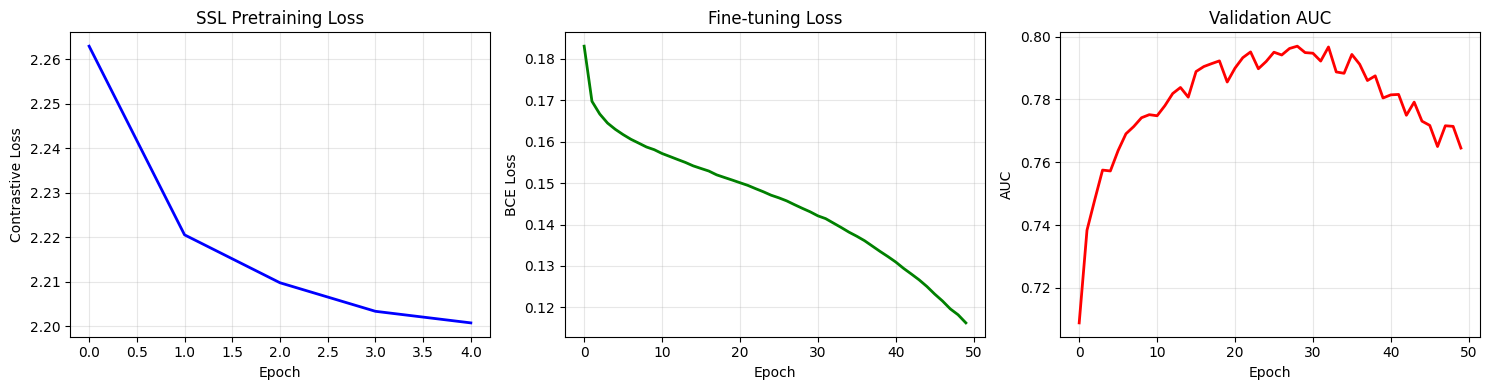

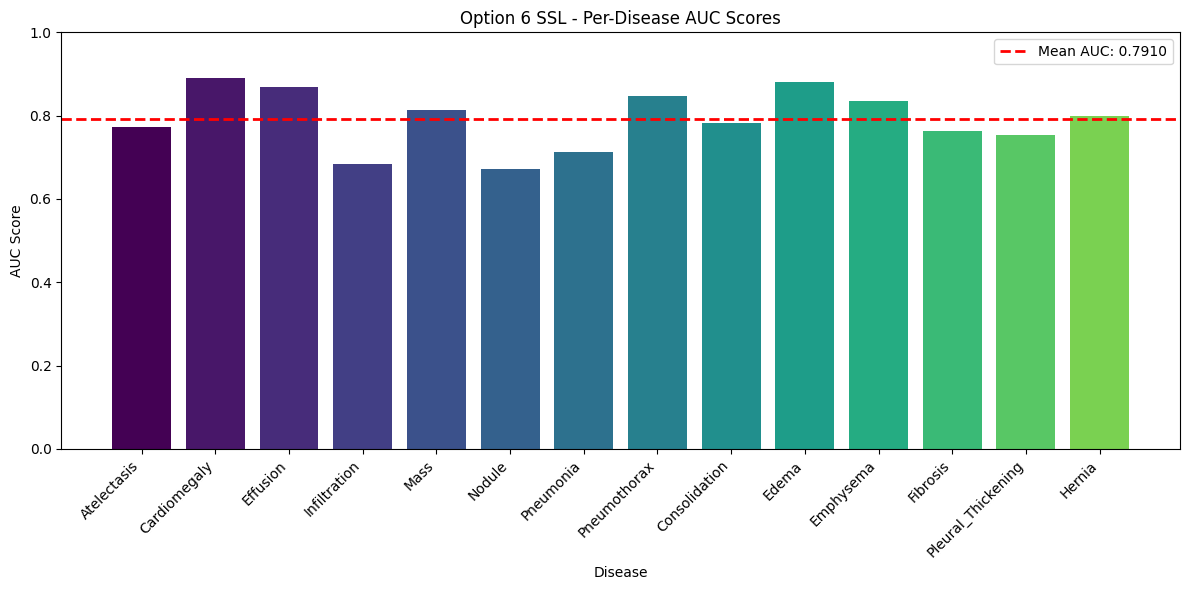

✅ Visualizations saved


In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Pretraining loss
axes[0].plot(pretrain_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Contrastive Loss')
axes[0].set_title('SSL Pretraining Loss')
axes[0].grid(True, alpha=0.3)

# Fine-tuning loss
axes[1].plot(train_losses, 'g-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('BCE Loss')
axes[1].set_title('Fine-tuning Loss')
axes[1].grid(True, alpha=0.3)

# Validation AUC
axes[2].plot(val_aucs, 'r-', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Validation AUC')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'option6_ssl_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Disease-wise AUC bar plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(disease_categories)))
bars = ax.bar(disease_categories, disease_aucs, color=colors)
ax.axhline(y=test_auc, color='red', linestyle='--', linewidth=2, label=f'Mean AUC: {test_auc:.4f}')
ax.set_xlabel('Disease')
ax.set_ylabel('AUC Score')
ax.set_title('Option 6 SSL - Per-Disease AUC Scores')
ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig(checkpoint_dir / 'option6_ssl_disease_aucs.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved")

## 14. Sample Predictions Visualization

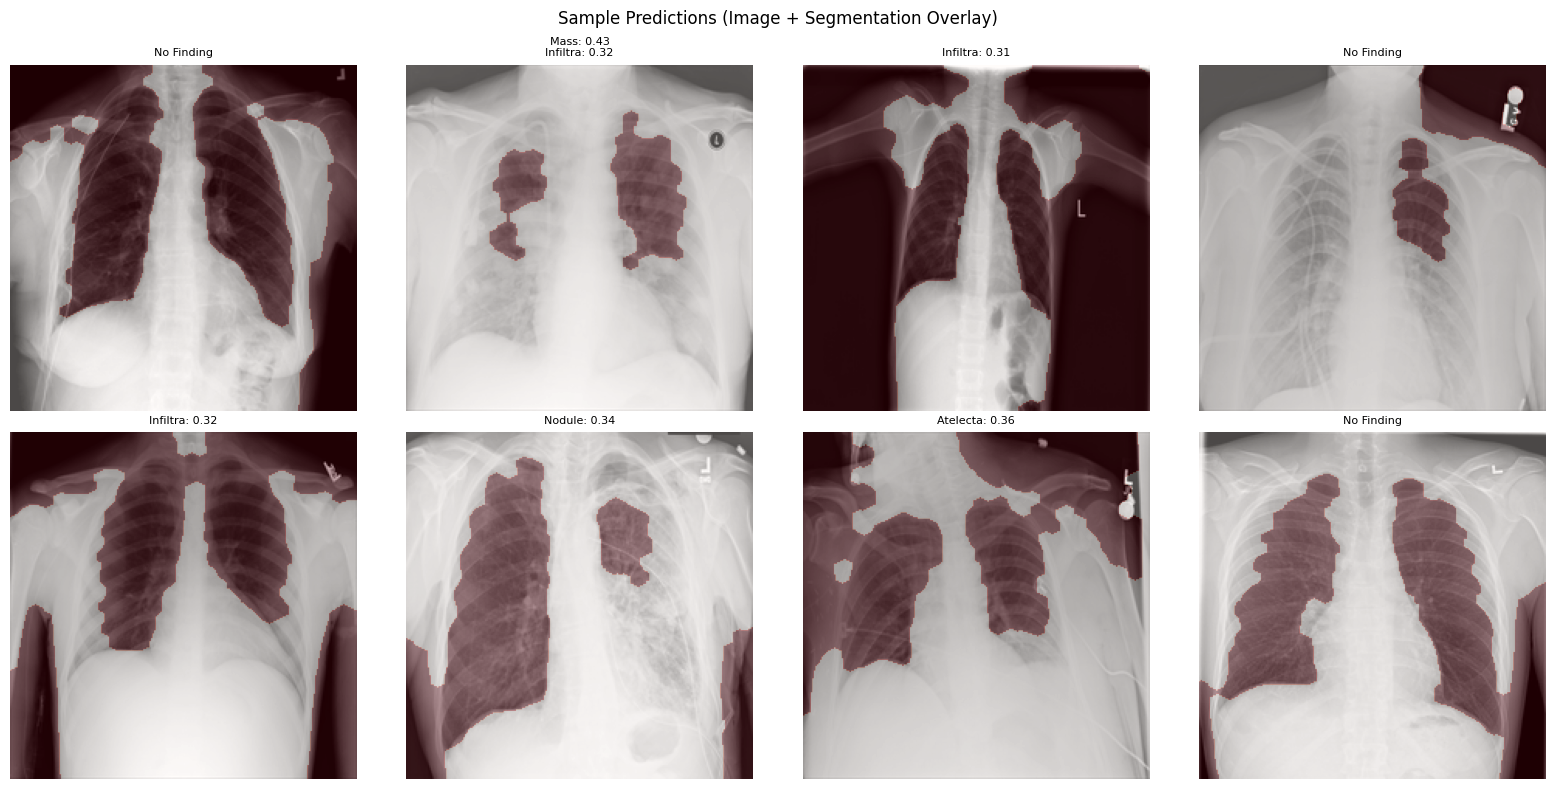

✅ Sample predictions visualized


In [48]:
# Visualize sample predictions
classifier.eval()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        idx = i * 4 + j
        sample, label = test_dataset[idx]
        
        with torch.no_grad():
            pred = torch.sigmoid(classifier(sample.unsqueeze(0).to(cfg.device)))
        
        # Show original image (channel 0)
        ax.imshow(sample[0].numpy(), cmap='gray')
        
        # Show mask as overlay
        mask_overlay = sample[1].numpy()
        ax.imshow(mask_overlay, cmap='Reds', alpha=0.3)
        
        # Get top predictions
        pred_np = pred.cpu().numpy().flatten()
        top_idx = pred_np.argsort()[-3:][::-1]
        
        title_lines = []
        for tidx in top_idx:
            if pred_np[tidx] > 0.3:
                title_lines.append(f"{disease_categories[tidx][:8]}: {pred_np[tidx]:.2f}")
        
        ax.set_title('\n'.join(title_lines) if title_lines else 'No Finding', fontsize=8)
        ax.axis('off')

plt.suptitle('Sample Predictions (Image + Segmentation Overlay)', fontsize=12)
plt.tight_layout()
plt.savefig(checkpoint_dir / 'option6_ssl_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Sample predictions visualized")

## Summary

This notebook implemented **Option 6 with SSL**:

1. **2-Channel Input**: Combined grayscale image + rule-based lung segmentation mask
2. **SSL Pretraining**: Contrastive learning (NT-Xent loss) to learn representations
3. **Fine-tuning**: Multi-label classification for 14 diseases

### Key Benefits:
- Preserves all original image information
- Provides anatomical context through segmentation channel
- SSL pretraining helps learn robust features before supervised learning
- Consistent augmentations applied to both image and mask channels